# Imports #

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import linregress
from scipy.stats import zscore

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Import custom functions from 'regression_functions.py' ##
try:
    import importlib
    importlib.reload(fn)
except NameError: # It hasn't been imported yet
    import supervised_learning_functions as fn
    
sns.set()

# Data reading and cleaning #

**1. Upload data and check for missing values**

In [3]:
df = pd.read_csv('MBA_ADMISSIONS.csv')
display(df.info()) #does the non-null count of every column match the index range of the dataframe?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   pre_score                     473 non-null    float64
 1   Age_in_years                  473 non-null    int64  
 2   Percentage_in_10_Class        473 non-null    float64
 3   Percentage_in_12_Class        473 non-null    float64
 4   Percentage_in_Under_Graduate  473 non-null    float64
 5   percentage_MBA                473 non-null    float64
 6   post_score                    473 non-null    float64
 7   Gender                        473 non-null    object 
 8   STATE                         473 non-null    object 
 9   Previous_Degree               473 non-null    object 
 10  Marital_status                473 non-null    object 
 11  Place_you_belong_to           473 non-null    object 
 12  perceived#Job#Skill           473 non-null    object 
 13  Speci

None

**2. Split data into categorical feature matrix, numerical feature matrix, and target vector**

In [4]:
X_df = df.drop('pre_score', axis=1) #select all columns except 'pre_score'
X_cat_df = X_df.T[X_df.dtypes == object].T #select all categorical columns of X
X_num_df = X_df.drop(X_cat_df.columns, axis=1) #select all numerical columns of X

y_df = df[['pre_score']]
y = y_df.to_numpy().reshape(-1)

**3. Perform one-hot encoding on categorical features and combine with numerical features**

In [5]:
X_cat = X_cat_df.to_numpy() #transform categorical feature matrix to numpy array for sklearn

encode = OneHotEncoder() #define encoding model
encode.fit(X_cat) #fit encoding model to categorical feature array

encoded_data = encode.transform(X_cat).toarray() #transform categorical feature matrix to encoded data
encoded_column_names = encode.get_feature_names_out(X_cat_df.columns) #get new column names of encoded data
X_cat_encoded_df = pd.DataFrame(encoded_data, columns=encoded_column_names) #create a new dataframe of the encoded data (with column names)

X_pre_processed_df = pd.concat([X_num_df, X_cat_encoded_df], axis=1) #combine numerical data with encoded categorical data
X_pre_processed = X_pre_processed_df.to_numpy() #convert combined dataframe into numpy array

# EDA #

**1. Plot distribution of target variable (i.e. is it skewed/normal/binomial, what are realistic predictions that the model could make etc.?)**

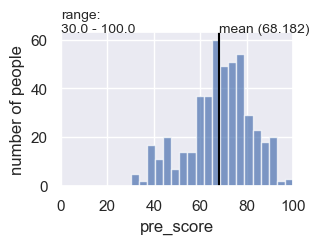

In [6]:
## Plot histogram ##
plt.figure(figsize=(3,2))
plt.hist(y, bins=20,alpha=0.7)

## Plot mean of distribution ##
mean = round(np.mean(y),3)
plt.axvline(mean, color='black')
plt.text(x=mean, y=plt.ylim()[1],
         s=f'mean ({mean})',
         fontsize=10)

## Annotate plot with range of distribution ##
plt.text(x=0, y=plt.ylim()[1],
         s=f'range:\n{np.min(y)} - {np.max(y)}',
         fontsize=10)

## Set axes ##
plt.xlim(0,100)
plt.xlabel('pre_score')
plt.ylabel('number of people');

- It looks like a relatively normal distribution that is slightly negatively skewed, so we would expect there to be more variability with the lower scores
- If the model begins to predict scores significantly below 30 then we know that there is something strange happening. Alternatively, the model may struggle to predict low scores accurately due to lack of training data on low scores (there are only ~60 people with pre_scores < 50)?
- Is this a scenario where we might consider doing a manually coded stratified kfold, where you manually select at least X number of scores < 50 in each fold, for example?

**2. Plot correlations of numerical features against target variable**

In [7]:
## Functions used from regression_functions.py ##
    #fn.plot_bestfit_line

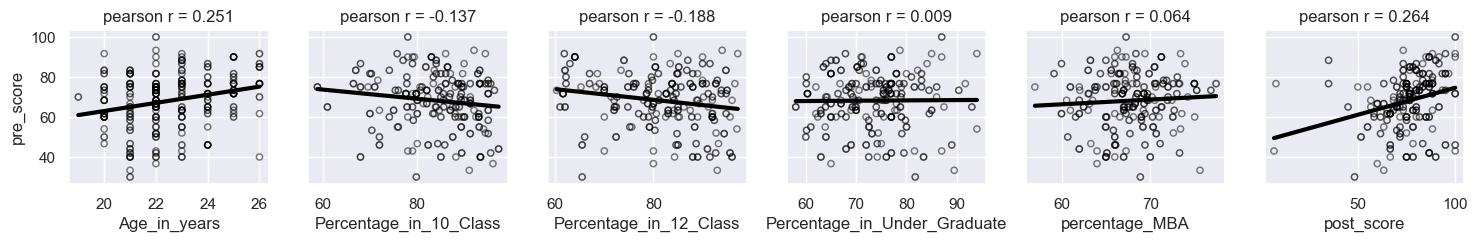

In [8]:
## Initialize subplots to add correlation scatter plots to ##
fig, ax = plt.subplots(nrows=1, ncols=X_num_df.shape[1], #number of columns is the number of numerical features
                       figsize=(18,2), sharey=True)

## Loop through each feature and add subplots ##
for col, (feature, data) in enumerate(X_num_df.items()):
    r = round(pearsonr(data, y)[0],3) #calculate pearson r correlation coefficient
    ax[col].scatter(data, y, s=20, facecolor='None', edgecolor='black', alpha=0.3) #scatter plot of feature vs. 'pre_score'
    fn.plot_bestfit_line(data, y, ax[col]) #use function defined at beginning to add a line of best fit to the scatter plot
    
    ## Set axes and titles ##
    ax[col].set_xlabel(feature, fontsize=12)
    ax[col].set_title(f'pearson r = {r}')
ax[0].set_ylabel('pre_score'); #only need to show y-label on first subplot as it is the same for all subplots

- At first glance, post_score seems to be most correlated with pre_score, and this correlation may be even stronger if the low post_score "outliers" are removed (i.e. < 50, which could be considered people who "failed" the post_test). While this is not enough to justify removing these data points, it may give us a better idea of the "true" correlation between post_score and pre_score (see the cell below)
- Age seems to be on quite a different scale to all of the other numerical features, which are presumably scores out of 100. Maybe these features could be standardized.

**3. Plot correlations of "post_score" vs. "pre_score" with outliers removed - is the correlation stronger?**

In [9]:
## Functions used from regression_functions.py ##
    #fn.plot_bestfit_line

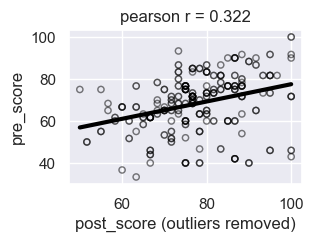

In [10]:
fig, ax = plt.subplots(figsize=(3,2)) #initialize figure

## Data filtering to select only datapoints where "post_score" >= 50 ##
post_score_df = df[['post_score','pre_score']]
post_score_df_filtered = post_score_df[post_score_df['post_score'] >= 50]
x_filtered = post_score_df_filtered['post_score'].to_numpy() 
y_filtered = post_score_df_filtered['pre_score'].to_numpy()

## Calculate new pearson correlation coefficient and plot resulting scatterplot (same as previous cell) ##
r = round(pearsonr(x_filtered, y_filtered)[0],3)
ax.scatter(x_filtered, y_filtered, s=20, facecolor='None', edgecolor='black', alpha=0.3)
fn.plot_bestfit_line(x_filtered, y_filtered, ax)

## Set axes and title ##
ax.set_xlabel('post_score (outliers removed)', fontsize=12)
ax.set_title(f'pearson r = {r}')
ax.set_ylabel('pre_score');

**3. Is there a correlation between our numerical features (i.e. can the model be simplified)?**
**Let us consider features with pairwise correlation | r | > 0.5 as "highly correlated"**

In [11]:
feature_correlation_num = X_num_df.corr() #create correlation matrix
feature_correlation_num[abs(feature_correlation_num) > 0.5] #only show correlation coefficients if the absolute value > 0.5

,Age_in_years,Percentage_in_10_Class,Percentage_in_12_Class,Percentage_in_Under_Graduate,percentage_MBA,post_score
Age_in_years,1.0,NaN,NaN,NaN,NaN,NaN
Percentage_in_10_Class,NaN,1.0,NaN,NaN,NaN,NaN
Percentage_in_12_Class,NaN,NaN,1.0,NaN,NaN,NaN
Percentage_in_Under_Graduate,NaN,NaN,NaN,1.0,NaN,NaN
percentage_MBA,NaN,NaN,NaN,NaN,1.0,NaN
post_score,NaN,NaN,NaN,NaN,NaN,1.0


- None of the numerical features are "highly correlated" with eachother, and so there are likely no redundancies in terms of the complexity of the model (at least for numerical features). Further feature selection could be done on the categorical features/full model using techniques such as regularization, testing for collinearity of features, or dimensionality reduction prior to model training/validation (but only if the number of features was much higher than the current dataset)?

**4. Plot a correlation matrix heatmap with the color intensity bounded between 0 and 0.5 (since there are no pairwise correlations > 0.5)**

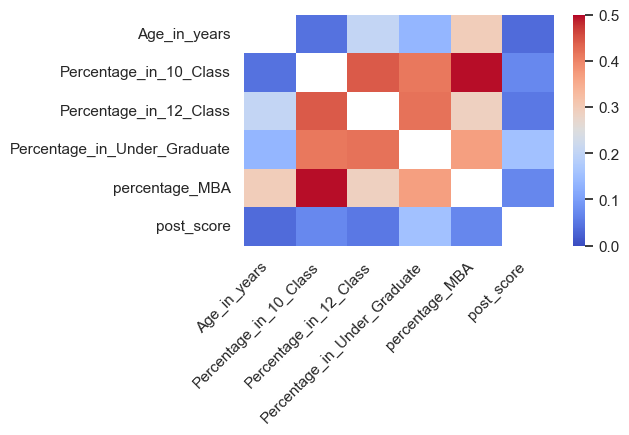

In [12]:
## Figure parameters ##
plt.figure(figsize=(5,3)) #initialize figure
sns.set_style('white') #set background to white

## Create heatmap ##
mask = feature_correlation_num == 1 #create a boolean mask to hide the diagonal of the correlation matrix (i.e. where r = 1)
sns.heatmap(abs(feature_correlation_num), vmin=0, vmax=0.5, cmap='coolwarm', mask=mask) #plot resulting heatmap with boolean mask

## Set axis parameters ##
xloc = list(range(feature_correlation_num.shape[1])) #locations of x-ticks
xtick_loc = [x+0.5 for x in xloc] #add 0.5 to each x-tick to be placed at the centre of each square
plt.xticks(xtick_loc, 
           feature_correlation_num.columns,
           rotation = 45, #angle the xtick labels
           ha='right'); #position the xtick labels

- The most striking thing here is how uncorrelated "post_score" is with the other features, suggesting that we can have confidence that this is an independent feature
- "Age_in_years" also looks fairly independent
- The other features look less convincing (i.e. the middle 4 x 4 grid looks relatively hot)
- The correlation between "Percentage_MBA" and "Percentage_in_10_Class" is highest. If I were to remove one of them, it would be "Percentage_in_10_Class" since its correlation with the other features (i.e. "Percentage_in_12_Class" and "Percentage_in_Under_Graduate") is higher

**5. Plot proportion of classes in each categorical variable (i.e. do we have balanced categorical features?)**

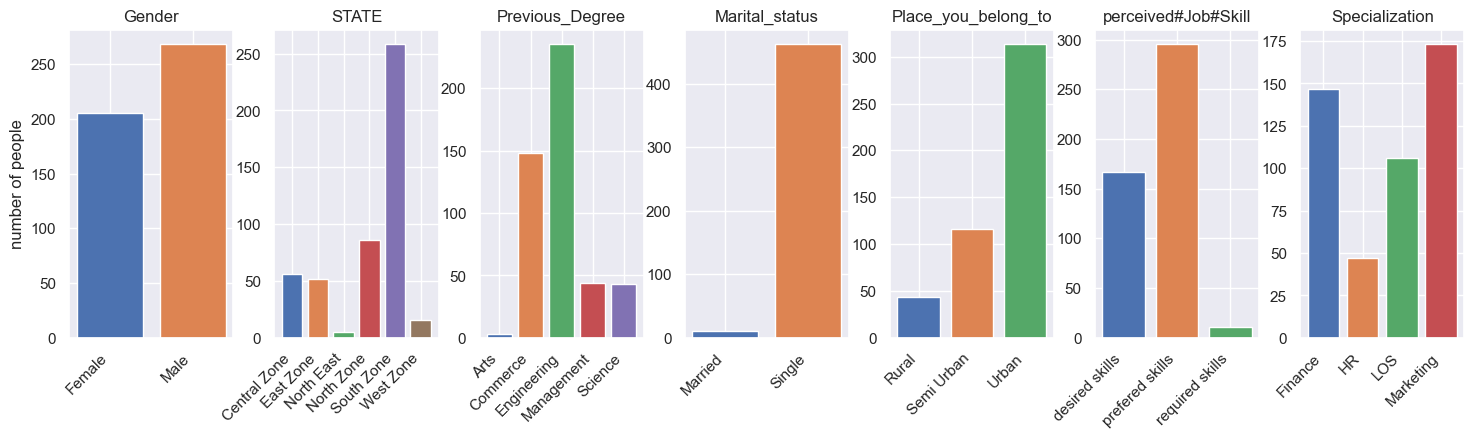

In [13]:
## Initialize subplots figure ##
sns.set()
fig, ax = plt.subplots(nrows=1, ncols=X_cat_df.shape[1], #make a separate subplot column for each categorical feature
                       figsize=(18,4), sharey=False, #don't share y-axis as we only care about within subplot comparisons
                       gridspec_kw={'wspace':0.25})

## Loop through each categorical feature and make a subplot for each feature ##
for col, (feature, data) in enumerate(X_cat_df.items()):
    data_df = data.to_frame() #convert data to pandas to enable groupby functions
    class_counts = data_df.groupby(feature).size().to_frame() #count the numbers of each class within a categorical feature
    
    ## Loop through each class within a categorical feature and plot class numbers ##
    for x, (class_name, count) in enumerate(class_counts.iterrows()): #unpack class name and class count from groupby object
        ax[col].bar(x, count)
        
    ## Set subpot axes and titles for the current cateogrical feature in the outer loop ##
    ax[col].set_title(feature)
    ax[col].set_xticks(list(range(class_counts.shape[0])))
    ax[col].set_xticklabels(class_counts.index, rotation=45, ha='right')
ax[0].set_ylabel('number of people'); #only need to show y-label on first subplot as it is the same for all subplots

- At the very least, it looks like marital status may not be a great predictor in this model as there are barely any married people in this dataset

# Data splitting and model training/validation #

**1. Define a function that defines/fits model, and returns accuracy metrics**

In [14]:
## Functions used from regression_functions.py ##
    # fn.train_validate

**2. Set-up 5-fold cross validation for data splitting**

In [15]:
k_fold = KFold(5, shuffle=True, random_state=42)

**3. Define a function that incorporates cross-validation**

In [16]:
## Functions used from regression_functions.py ##
    # fn.pipeline

**4. Plot accuracy metrics of model after training the model**

In [17]:
## Functions used from regression_functions.py ##
    # fn.pipeline
    # fn.train_validate
    # fn.calculate_adjusted_R2
    # fn.plot_metric

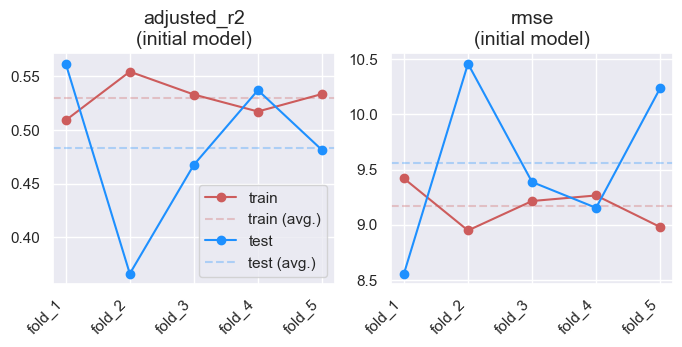

In [23]:
predictions, scores, models_fit = fn.pipeline('lin_reg', k_fold, X_pre_processed, y)

sns.set()
fig, ax = plt.subplots(nrows=1, ncols=2,
                       figsize=(8,3))
for col, metric in enumerate(['adjusted_r2','rmse']):
    metric_df = scores.T[scores.T.index.str.contains(metric)].T
    fn.plot_metric(metric_df, metric, 'initial model', ax[col], col)

- On average, the test accuracies seem to be worse than the train accuracies, so there is probably a bit of over-fitting going on. Maybe could consider less folds in the cross-validation to get a larger proportion of testing data to training data.
- There seems to be a decent amount of variability across folds in the test scores (for both r2 and rmse). Maybe this is on the low pre_scores (i.e. < 50), which makes up the left tail of the distribution (section 1. of EDA)?

**5. Plot the distribution of "pre_score" for each fold to see if fold 2 looks different from the others**

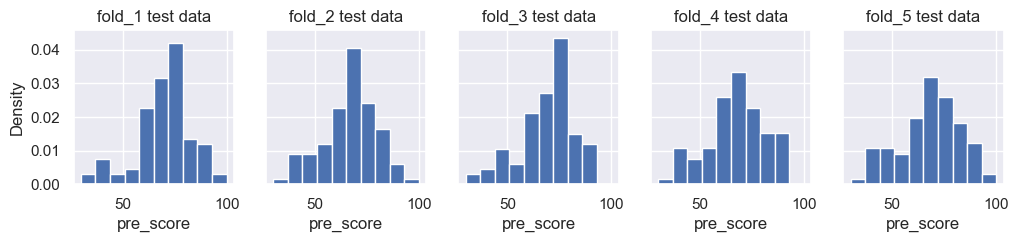

In [24]:
sns.set()
fig, ax = plt.subplots(nrows=1, ncols=5,
                       figsize=(12,2),
                       sharey=True, sharex=True)

xmin = y.min()
xmax = y.max()
bins = np.linspace(xmin, xmax, 11)
for k, (train, test) in enumerate(k_fold.split(X_pre_processed)):
    y_test = y[test]
    ax[k].hist(y_test,
            bins=bins, density=True)
    ax[k].set_title(f'fold_{k+1} test data')
    ax[k].set_xlabel('pre_score')
ax[0].set_ylabel('Density');

- My hunch was wrong.

**6. Plot coefficients to determine which features are contributing to the model**

In [25]:
## Functions used from regression_functions.py ##
    # fn.plot_weights
    # fn.subplot_weights    

In [26]:
## Define colors you want to use for each categorical feature ##
categorical_colors = {'Gender':'dodgerblue',
                      'STATE':'darkorange',
                      'Previous_Degree':'seagreen',
                      'Marital_status':'indianred',
                      'Place_you_belong_to':'pink',
                      'perceived#Job#Skill':'grey',
                      'Specialization':'blueviolet'}

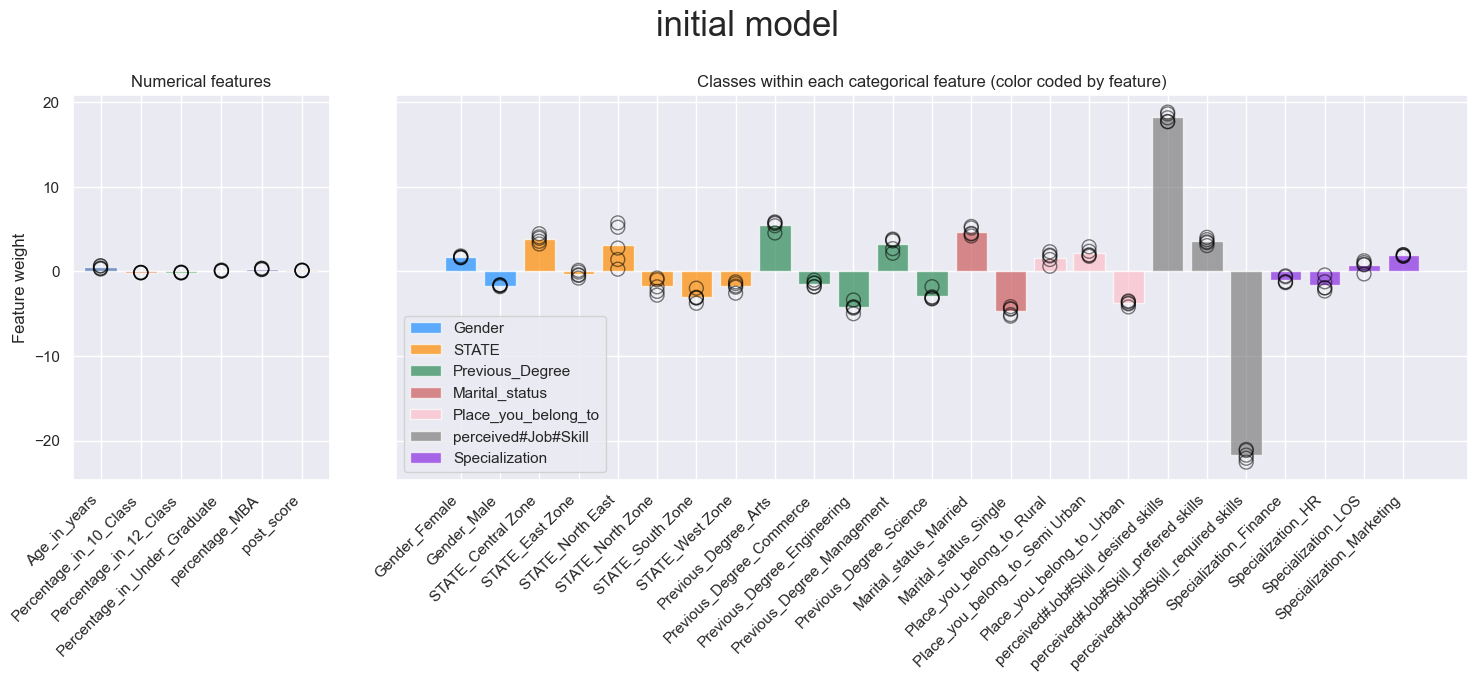

In [30]:
all_feature_names = X_pre_processed_df.columns
numerical_feature_names = X_num_df.columns
categorical_class_names = X_cat_encoded_df.columns

numeric_ratio = len(numerical_feature_names) / len(all_feature_names)
categorical_ratio = len(categorical_class_names) / len(all_feature_names)
title = 'initial model'

sns.set()
fn.subplot_weights(models_fit[1], all_feature_names, numerical_feature_names, categorical_class_names, 
                   numeric_ratio, categorical_ratio, categorical_colors, title)

- The biggest take away from these plots is that perceived job skill has a big impact on pre_score, where you tend to score higher if you have the desired skills, but lower if you only have the required skills.

**7. Now let's try to make a better model with some EDA-driven feature selection**
- first show model with all features included for reference
- try removing marital status since there is negligible representation of married people in this dataset
- try removing numerical features since they had low weights in the model
- finally, remove perceived job skill to show how big of an impact it has on the model

In [31]:
## Functions used from regression_functions.py ##
    # fn.calculate_adjusted_R2
    # fn.train_validate
    # fn.pipeline
    # fn.plot_weights
    # fn.subplot_weights    
    # fn.apply_feature_selection

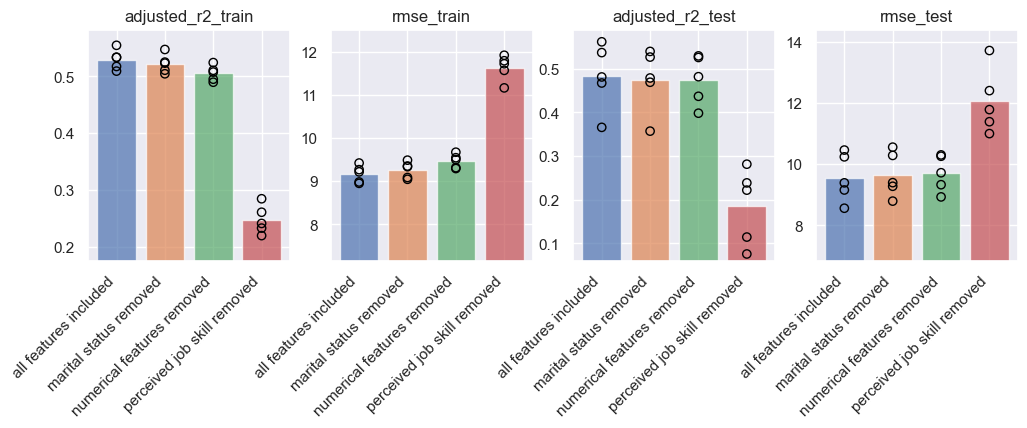

In [35]:
models_to_test = {'all features included':[],
                  'marital status removed':['Marital_status'],
                  'numerical features removed':X_num_df.columns,
                  'perceived job skill removed':['perceived#Job#Skill']}
EDA_scores, EDA_models_fit = fn.apply_feature_selection('lin_reg', models_to_test, X_pre_processed_df, y, k_fold)

- Seems like neither feature selection method worked very well, as the accuracy metrics were best with all features included

**8. Normalize numerical features (to be bounded between 0 and 1) to see if it improves model performance**

In [36]:
## Functions used from regression_functions.py ##
    # fn.calculate_adjusted_R2
    # fn.train_validate
    # fn.pipeline
    # fn.plot_weights
    # fn.subplot_weights    
    # fn.input_feature_matrixes

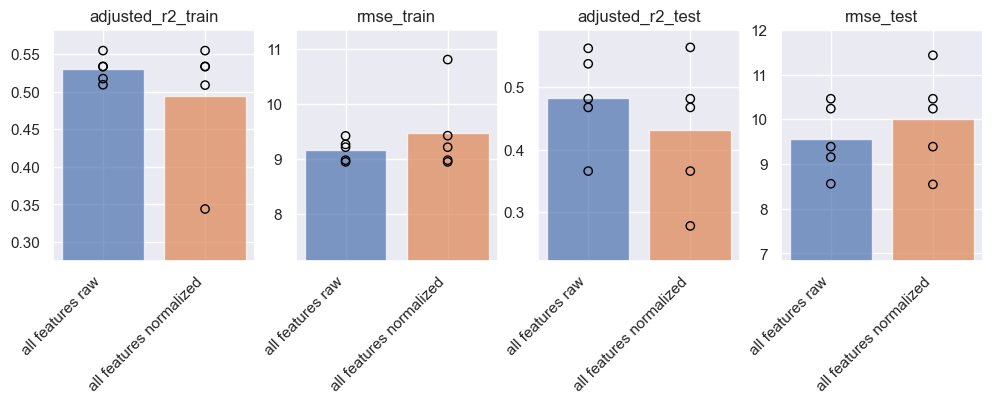

In [39]:
normalized_X_df = (X_pre_processed_df - X_pre_processed_df.min()) / (X_pre_processed_df.max() - X_pre_processed_df.min())
normalized_df = pd.concat([normalized_X_df, y_df], axis=1)
raw_df = pd.concat([X_pre_processed_df, y_df], axis=1)
models_to_test = {'all features raw':raw_df,
                  'all features normalized':normalized_df}
norm_features_scores, norm_features_models_fit = fn.input_feature_matrixes('lin_reg', models_to_test, k_fold);

- Normalizing the numerical features made the model accuracy worse, so the fact that they were on different scales was not underestimating the model accuracy

**9. Forward feature selection**

In [42]:
## Functions used from regression_functions.py ##
    # fn.calculate_adjusted_R2
    # fn.train_validate
    # fn.pipeline
    # fn.plot_weights
    # fn.subplot_weights    
    # fn.ffs
    # fn.apply_feature_selection

In [43]:
verbose = False #set to True if you want to track features as they are added
included, included_encoded = fn.ffs('lin_reg', X_df, X_pre_processed_df, y, k_fold, verbose)

********************************************************************************
Best model has 10 features:
['perceived#Job#Skill', 'STATE', 'Place_you_belong_to', 'Previous_Degree', 'Marital_status', 'Percentage_in_10_Class', 'Gender', 'post_score', 'Percentage_in_12_Class', 'Age_in_years']

Best model has 25 encoded features:
['Age_in_years', 'Percentage_in_10_Class', 'Percentage_in_12_Class', 'post_score', 'Gender_Female', 'Gender_Male', 'STATE_Central Zone', 'STATE_East Zone', 'STATE_North East', 'STATE_North Zone', 'STATE_South Zone', 'STATE_West Zone', 'Previous_Degree_Arts', 'Previous_Degree_Commerce', 'Previous_Degree_Engineering', 'Previous_Degree_Management', 'Previous_Degree_Science', 'Marital_status_Married', 'Marital_status_Single', 'Place_you_belong_to_Rural', 'Place_you_belong_to_Semi Urban', 'Place_you_belong_to_Urban', 'perceived#Job#Skill_desired skills', 'perceived#Job#Skill_prefered skills', 'perceived#Job#Skill_required skills']


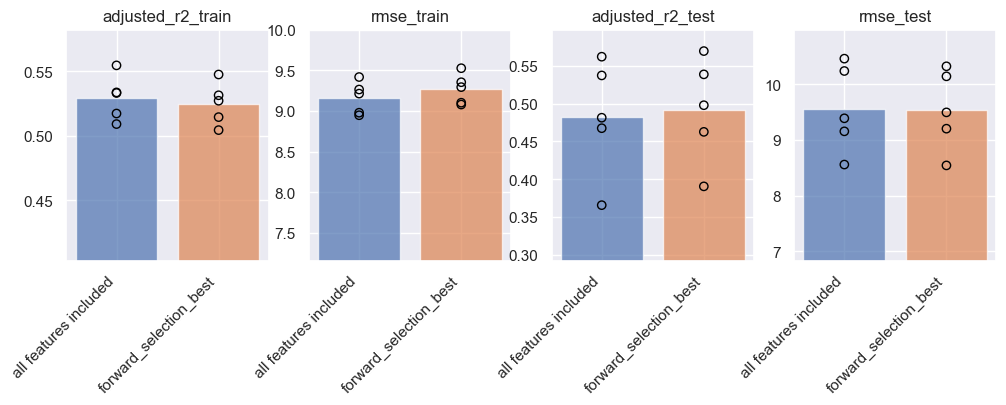

In [44]:
models_to_test = {'all features included':[],
                  'forward_selection_best':[x for x in X_df.columns if x not in included]}
ffs_scores, ffs_models_fit = fn.apply_feature_selection('lin_reg', models_to_test, X_pre_processed_df, y, k_fold)

- The forward feature selection model performed better on testing data, but worse on training data. This is definitely a better model since there was some overfitting happening in the initial model (i.e. with all features selected).

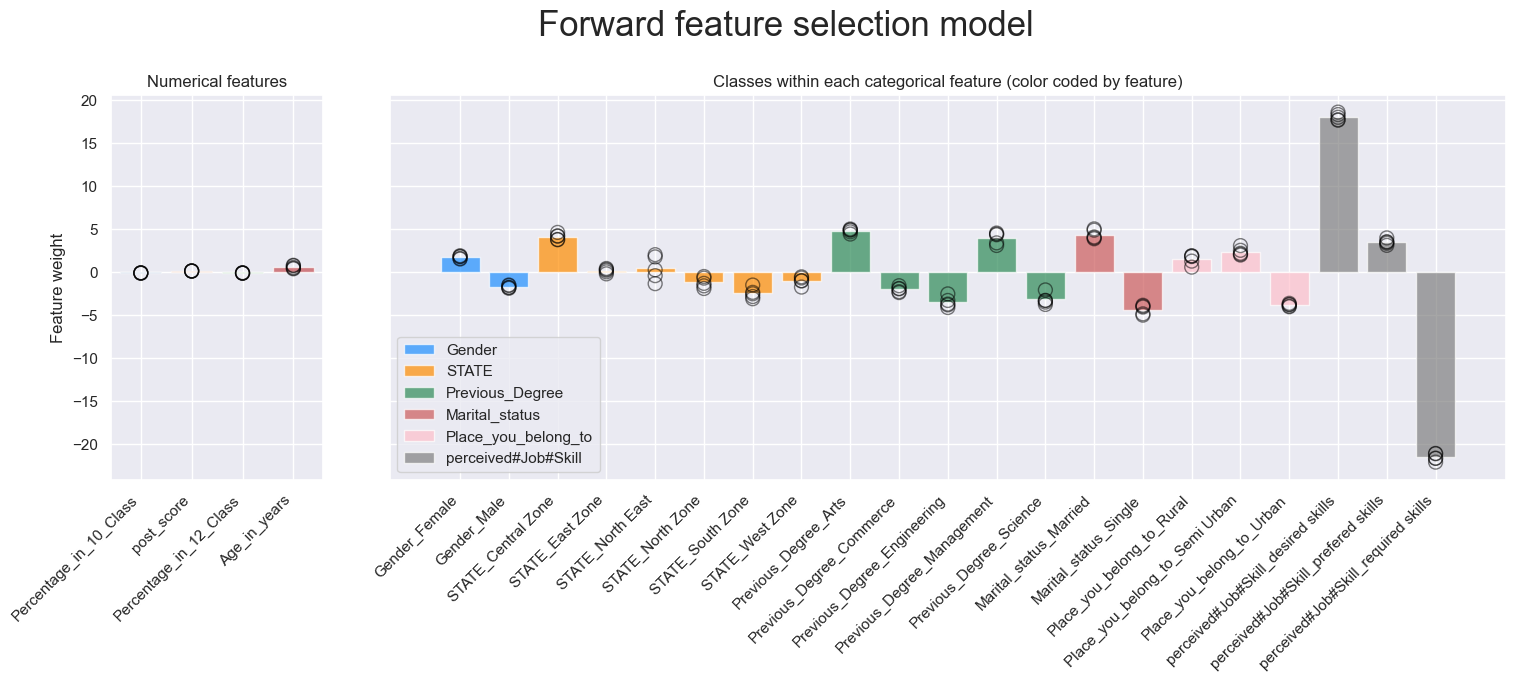

In [46]:
title = "Forward feature selection model"
ffs_model = ffs_models_fit['forward_selection_best']
ffs_all_feature_names = np.array(included_encoded)
ffs_numerical_feature_names = np.array([x for x in included if x in numerical_feature_names])
ffs_categorical_class_names = np.array([x for x in included_encoded if x in categorical_class_names])
ffs_numeric_ratio = len(ffs_numerical_feature_names) / len(ffs_all_feature_names)
ffs_categorical_ratio = len(ffs_categorical_class_names) / len(ffs_all_feature_names)

fn.subplot_weights(ffs_model[1], 
                ffs_all_feature_names, ffs_numerical_feature_names, ffs_categorical_class_names, 
                ffs_numeric_ratio, ffs_categorical_ratio, categorical_colors, title)

- Once again, perceived job skill seems to be the most important factor in predicting pre_scores.

**10. How about if we remove pre_score "outliers" < 50 (i.e. those who failed)?**
- If we remember our distribution of pre_scores (Section 1. of EDA), there was a tail to the left side of the distribution from about 50 and below

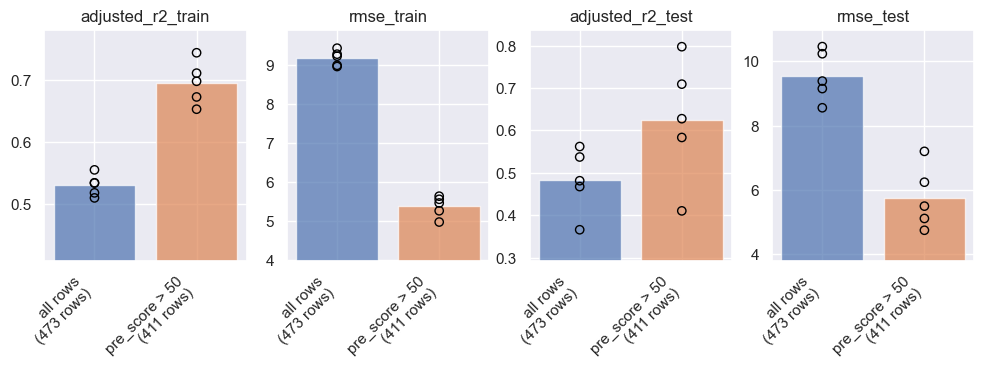

In [47]:
pre_filtered = pd.concat([X_pre_processed_df, y_df], axis=1)
filtered_df = pre_filtered[(pre_filtered['pre_score'] > 50)]
filtered_rows = filtered_df.shape[0]
raw_df = pd.concat([X_pre_processed_df, y_df], axis=1)
raw_rows = raw_df.shape[0]

models_to_test = {f'all rows\n ({raw_rows} rows)':raw_df,
                  f'pre_score > 50\n ({filtered_rows} rows)':filtered_df}
filtered_scores, filtered_models = fn.input_feature_matrixes('lin_reg', models_to_test, k_fold)

- Given that this filtered model performs better than the same model with all rows included, it seems as though the model may struggle to predict the pre_score of people who got a failing pre_score (i.e. < 50)
- It might be worth consulting an SME to see if this kind of filtering is appropriate for the problem.

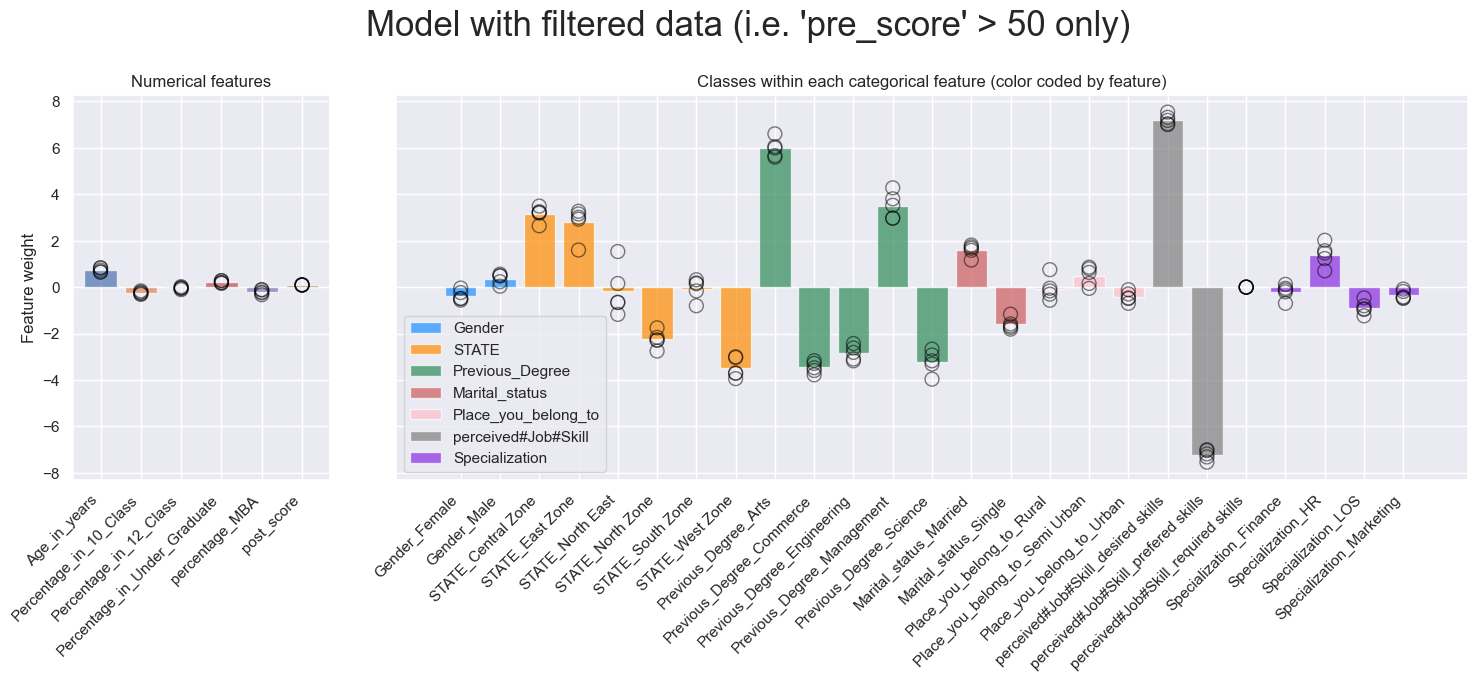

In [49]:
model_name = f'pre_score > 50\n ({filtered_rows} rows)'
title = "Model with filtered data (i.e. 'pre_score' > 50 only)"
fn.subplot_weights(filtered_models[model_name][1], all_feature_names, numerical_feature_names, categorical_class_names, 
                numeric_ratio, categorical_ratio, categorical_colors, title)

- Perceived job skill is again contributing the most to model accuracy, but now we are getting more contributions from previous degree and state. So not only is the accuracy higher in the filtered model, but the way in which the predictions are made has changed as well.